Background

The bandwidth and frequency covered by 6G wireless communication are unprecedented. According to the 6G white paper, at least the 300GHz~10THz band needs to be covered to meet the proposed key technical indicators (100Gbit/s~1Tbit/s peak transmission speed and 0.1ms level communication delay). In addition, the 6G wireless communication system will be a complex and ultra-dense heterogeneous network system in which multiple services coexist and numerous communication technologies are integrated [1]. In this scenario, an intelligent spectrum management system is required to manage spectrum resources, optimize network performance, and resolve the contradiction between supply and demand scientifically and efficiently. The research on cognitive-based intelligent spectrum management systems is imperative.

Overview

We announce a deep learning-based challenge to address an automatic modulation recognition task. Several datasets are composed of sub-Nyquist-rate time-domain samples on GHz bandwidth baseband signals [2,3]. Both training sets and testing sets are provided with labels indicating modulation of the signal. The task is to recognize the signal locations in the frequency domain indicated by pre-defined discrete channel indexes and the modulation types of the signals located somewhere in the baseband. Participants are required to train their models using the training set and verify their model with the verification set for the best possible performance. The submitted models will be evaluated on an unpublished test dataset. The competition will contain one basic challenge and one advanced challenge.


In [1]:

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import h5py
import time
import datetime
import random as python_random
import json
import gc
import pickle
from codecarbon import EmissionsTracker

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from IPython.display import display, HTML


# Introduction

In this section will define constant and load data from file


In [2]:
RANDOM_SEED = 100

# 16 orders 8 pairs of I/Q signals
ORDER = ["I1", "Q1", "I2", "Q2", "I3", "Q3", "I4", "Q4",
         "I5", "Q5", "I6", "Q6", "I7", "Q7", "I8", "Q8"]
# Module labels
MOD = ["APSK16", "APSK32", "APSK64", "ASK8", "BPSK", "OQPSK",
       "PSK16", "PSK8", "QAM128", "QAM16", "QAM256", "QAM64", "QPSK"]


In [3]:
# Configuration for Colab, make sure you have dataset store in a correct folder
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# DATASET_PATH = 'drive/MyDrive/TFM'
# TRAIN_FILEPATH=DATASET_PATH+'/data_1_train.h5'
# TEST_FILEPATH=DATASET_PATH+'/data_1_test.h5'


In [4]:
# Configuration for local machine
DATASET_PATH = 'dataset'
TRAIN_FILEPATH = DATASET_PATH+'/data_1_train.h5'
TEST_FILEPATH = DATASET_PATH+'/data_1_test.h5'


In [5]:
def load_data(filepath):
    """function that load datasett

    Args:
        file_name (string): path of dataset

    Returns:
        np.array: array of 
    """
    print("Load data from {}".format(filepath))
    with h5py.File(filepath, 'r') as f:
        print(f.keys())
        print("X shape:", f['X'].shape)
        print("Y shape:", f['Y'].shape)
        return np.array(f['X']), np.array(f['Y'])


In [6]:
X_data, Y_data = load_data(TRAIN_FILEPATH)
X_test_data, Y_test_data = load_data(TEST_FILEPATH)
print("Train Classes:", np.unique(Y_data,return_counts=True))
print("Test Classes:", np.unique(Y_test_data, return_counts=True))
print("Labels:", MOD)


Load data from dataset/data_1_train.h5
<KeysViewHDF5 ['X', 'Y']>
X shape: (124800, 1024, 16)
Y shape: (124800, 1)
Load data from dataset/data_1_test.h5
<KeysViewHDF5 ['X', 'Y']>
X shape: (31200, 1024, 16)
Y shape: (31200, 1)
Train Classes: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint8), array([9600, 9600, 9600, 9600, 9600, 9600, 9600, 9600, 9600, 9600, 9600,
       9600, 9600], dtype=int64))
Test Classes: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint8), array([2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
       2400, 2400], dtype=int64))
Labels: ['APSK16', 'APSK32', 'APSK64', 'ASK8', 'BPSK', 'OQPSK', 'PSK16', 'PSK8', 'QAM128', 'QAM16', 'QAM256', 'QAM64', 'QPSK']


# Data analysis

En esta parte se visualiza un ejemplo de cada clase, estadística de los datos y normalización de los datos


In [7]:
# Check nan value
if (np.isnan(X_data).any()):
    print("The dataset contains NaN values")
else:
    print("The dataset doesn't contains NaN values")


The dataset doesn't contains NaN values


In [8]:
print("max value:",np.max(X_data))
print("min value:",np.min(X_data))
print("mean value:",np.mean(X_data))
print("median value:", np.median(X_data))
print("standard deviation:",np.std(X_data))

max value: 8191
min value: -9348
mean value: 11.810113114577073
median value: 9.0
standard deviation: 3492.2451672070993


## Data visualization


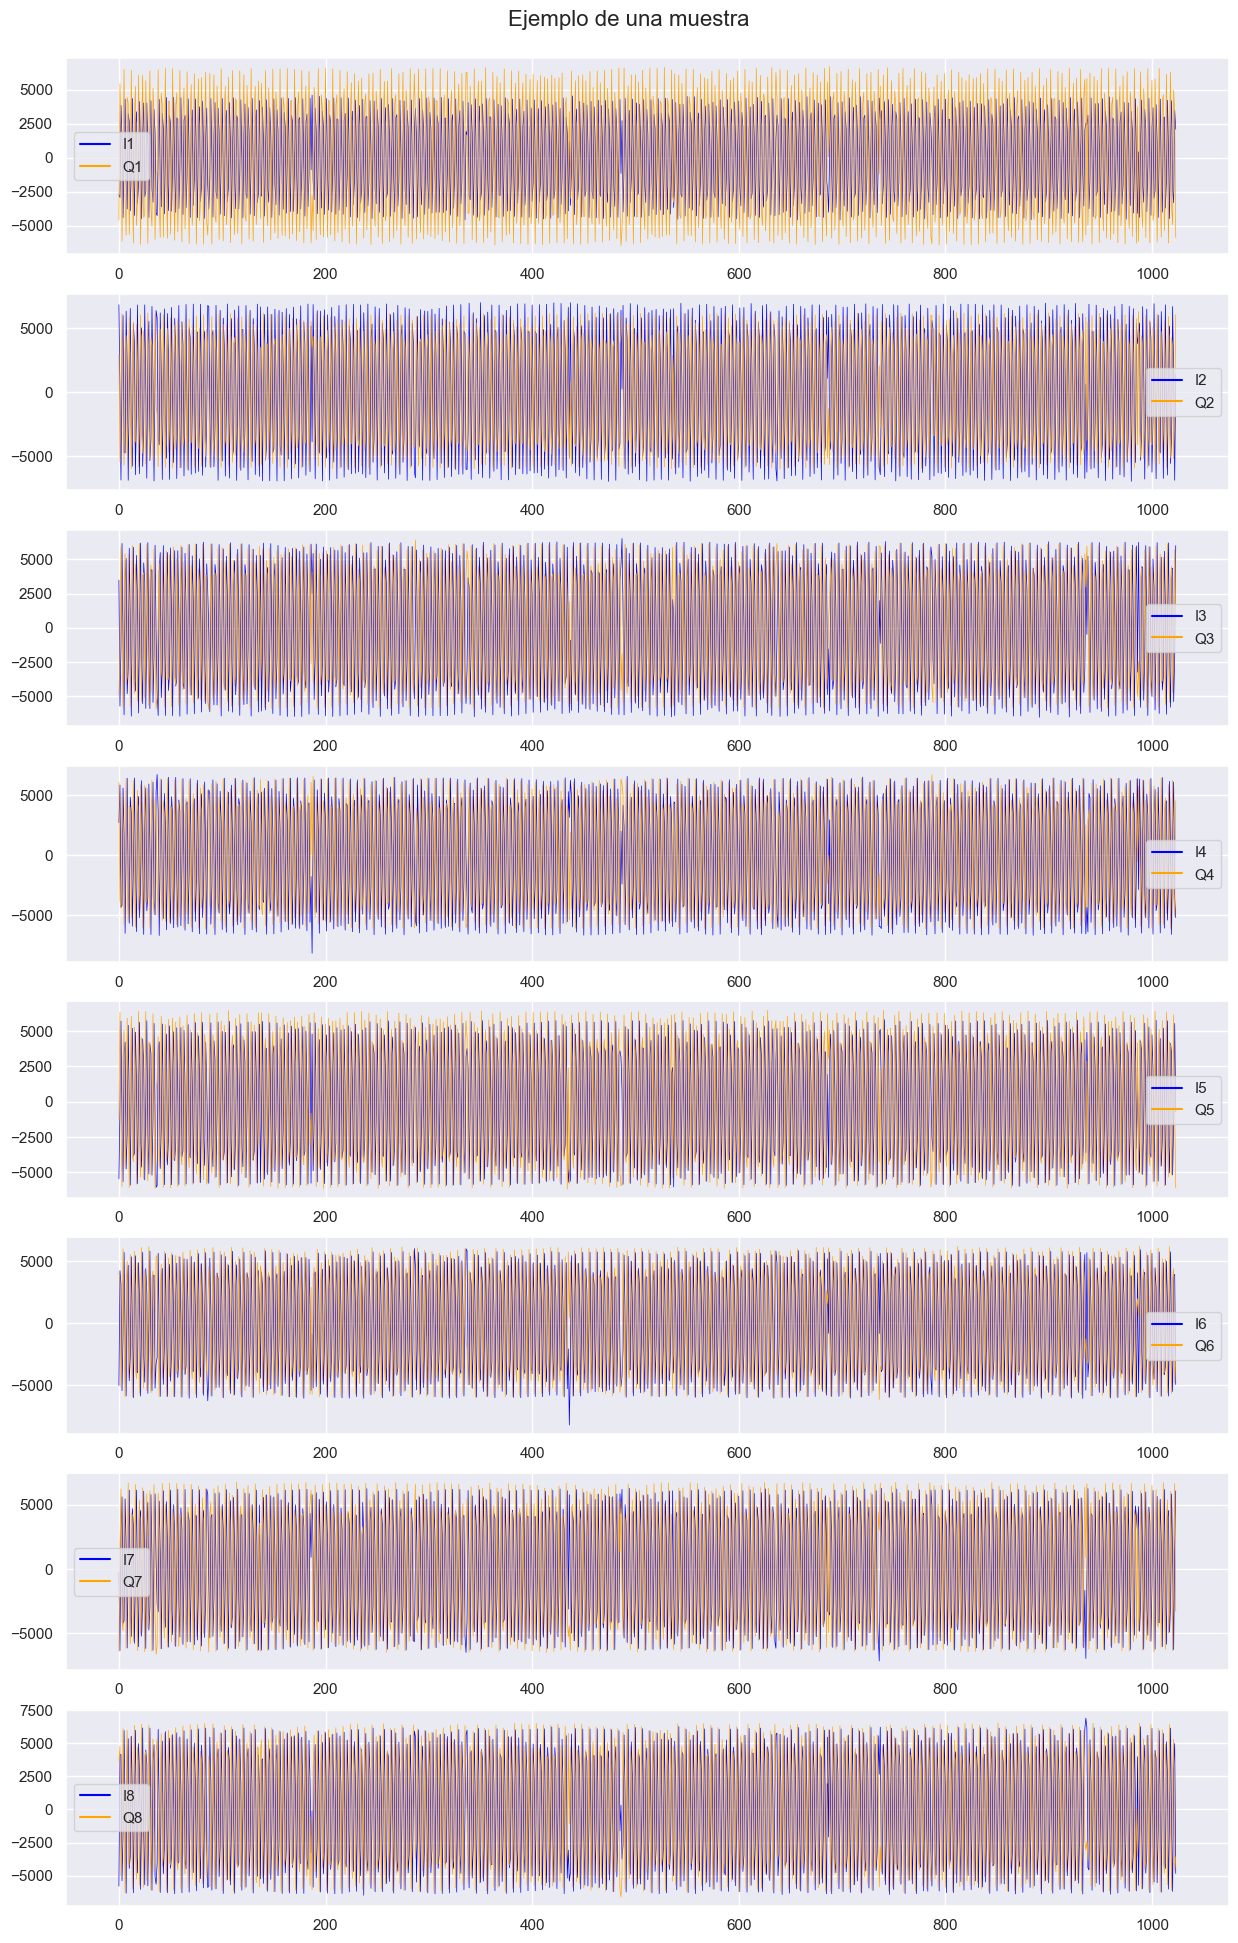

In [9]:
def plot_data(x, order_label=ORDER):
    """visualization of 1 sample

    Args:
        x (np.array): one sample
        order_label (_type_, optional): orders of signals. Defaults to ORDER.
    """
    x = np.transpose(x, [1, 0])
    order = x.shape[0]
    sns.set_theme()
    fig, axes = plt.subplots(int(order/2), 1,  figsize=(15, int(3*order/2)))
    fig.suptitle("Ejemplo de una muestra", size=16, y=0.90)

    for idx in range(int(order/2)):
        Iidx = idx*2
        Qidx = idx*2+1

        i = pd.DataFrame(data={
            order_label[Iidx]: x[Iidx]
        })

        q = pd.DataFrame(data={
            order_label[Qidx]: x[Qidx]
        })
        sns.lineplot(data=i, linewidth=0.5, palette=['blue'], ax=axes[idx])
        sns.lineplot(data=q, linewidth=0.5, palette=['orange'], ax=axes[idx])
    plt.show()


plot_data(X_data[0])


## Statistics by order and modulation


In [10]:
def get_by_IQ(x, orden=ORDER):
    """Get summary group by order

    Args:
        x (np.array): dataset with  16,1024 format
        orden (list, optional): orders of signals. Defaults to ORDER.

    Returns:
        Dataframe: statistic of each order
    """
    data = {}
    gc.collect()
    for i in range(len(orden)):
        order_name = orden[i]
        data[order_name] = np.transpose(x, [0, 2, 1])[:, i].flatten()
    df = pd.DataFrame(data=data)
    return df


dfIQ = get_by_IQ(X_data)
print(dfIQ.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
del dfIQ
gc.collect()


                 I1            Q1            I2            Q2            I3  \
count  127795200.00  127795200.00  127795200.00  127795200.00  127795200.00   
mean          28.82        -18.91         26.02         17.11         12.47   
std         2796.78       3530.36       3482.73       3468.95       3520.36   
min        -9348.00      -7957.00      -8192.00      -8083.00      -8192.00   
25%        -2031.00      -2628.00      -2380.00      -2569.00      -2542.00   
50%           27.00        -18.00         13.00         16.00          6.00   
75%         2106.00       2559.00       2434.00       2572.00       2585.00   
max         7461.00       8191.00       8191.00       8191.00       8191.00   

                 Q3            I4            Q4            I5            Q5  \
count  127795200.00  127795200.00  127795200.00  127795200.00  127795200.00   
mean          28.05          7.91         12.67         -8.85         15.24   
std         3494.36       3604.16       3592.25    

29419

In [11]:
def get_by_mod(x, y, modulation=MOD):
    """Get summary group by order

    Args:
        x (np.array): dataset with 16,1024 format
        orden (list, optional): modulation labels of dataset. Defaults to MOD.

    Returns:
        Dataframe: statistic of each modulation
    """
    data = {}
    gc.collect()
    for idx in range(len(modulation)):
        label = idx+1
        data[modulation[idx]] = np.transpose(
            x, [0, 2, 1])[np.where(y == label)].flatten()
    df = pd.DataFrame(data=data)
    return df


dfmod = get_by_mod(X_data, Y_data, modulation=MOD)
print(dfmod.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
dfmod = None
gc.collect()


           APSK16      APSK32      APSK64        ASK8        BPSK       OQPSK  \
count  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00   
mean        28.47       29.37       28.15       28.42       28.59       28.97   
std       2926.68     2764.42     2773.52     2257.20     3091.84     3200.73   
min      -8631.00    -8526.00    -8517.00    -8052.00    -8532.00    -8475.00   
25%      -2169.00    -2007.00    -2028.00    -1158.00    -2265.00    -2907.00   
50%         30.00       30.00       27.00       30.00       36.00       21.00   
75%       2247.00     2082.00     2100.00     1227.00     2355.00     2970.00   
max       7152.00     6927.00     7425.00     6807.00     7461.00     7425.00   

            PSK16        PSK8      QAM128       QAM16      QAM256       QAM64  \
count  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00  9830400.00   
mean        28.86       29.08       28.85       29.59       29.12       28.84   
std       3151.87     3152.

0

# Model creation

In this section, different models based on neural networks are created using reduced dataset


In [12]:
# Use gpu when it's availaible
USE_GPU = True

# Percentage of data used for train and test, value are between 0-1, if the value is >= 1 then use full dataset
DATA_PROPORTION = 0.6
# use session id will continue executing previews
SESSION_ID = "20221219211946"

EXECUTION_FOLDER = SESSION_ID if SESSION_ID != "" else '{}'.format(
    datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
# The folder where the model is stored
MODEL_FOLDER = EXECUTION_FOLDER+'/model'


In [13]:

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(RANDOM_SEED)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(RANDOM_SEED)

# Moreover, when running on a GPU, some operations have non-deterministic outputs, in particular tf.reduce_sum().
# This is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed.
# Due to the limited precision of floats, even adding several numbers together may give slightly different results depending on the order in which you add them.


## Function for data transformation


In [14]:


def normalize_data(data):
    """ stand normalization along axis 0
    """
    data = data.astype('float64')
    mean = data[:, :, :].mean(axis=0)
    data[:, :, :] -= mean
    std = data[:, :, :].std(axis=0)
    data[:, :, :] /= std
    return data


def onehot(y):
    """onehot encoding for y 
    """
    return keras.utils.to_categorical(y-1)


def transform_dataset(X, Y):
    """transform X,Y into appropriate format for our models


    """
    return normalize_data(X), onehot(Y)


def get_split_transformed_data(X, Y, proportion, random_state=RANDOM_SEED):
    """return part of the data set according to the proportion

    Args:
        X : X of original dataset
        Y : Y of original dataset
        proportion (_type_): 0-1, percentage of data to return

    Returns:
        _type_: reduced data according to the proportion
    """
    if proportion >= 1 or proportion >= 1.0:
        return X, Y

    X_train, X_test, y_train, Y_test = train_test_split(
        X, Y, train_size=proportion, stratify=Y.flatten(), random_state=random_state)
    x_train_norm, y_train_onehot = transform_dataset(X_train, y_train)
    x_test_norm, y_test_onehot = transform_dataset(X_test, Y_test)
    return x_train_norm, y_train_onehot, x_test_norm, y_test_onehot


def get_n_split_transformed_data(x_data, y_data, n=3, random_state=RANDOM_SEED):
    """return Stratified split data set into N part
    """
    splits_idx = get_split_idx(y_data, n)
    split_data = []
    for i, split_idx in enumerate(splits_idx):
        x, y = x_data[split_idx], y_data[split_idx]
        x_train_norm, y_train_onehot = transform_dataset(x, y)
        split_data.append((x_train_norm, y_train_onehot))

    return split_data


def get_split_idx(y, n=2, random_state=RANDOM_SEED):
    """Stratified split dataset into n part

    """
    np.random.seed(random_state)
    classes = np.unique(y)
    classes_idx = []
    # generate random idx by class label

    for claz in classes:
        # get index of the class
        data_idx = np.where(y == claz)[0]
        # shuffle idx
        np.random.shuffle(data_idx)
        # split index into n part
        classes_idx.append(np.split(data_idx, n))
    # convert into np array
    idxs = np.array(classes_idx)
    # concat class of each split
    split_idx = np.concatenate(idxs, axis=1)
    # np.any(np.isin(split_idx[0], split_idx[1]))
    # np.all(np.isin(split_idx[0], split_idx[0]))
    return split_idx


## Transform data for training


In [15]:
input_shape = X_data.shape[1:]
num_classes = len(np.unique(Y_data))
print("input shape:", input_shape)
print("num classes:", num_classes)


input shape: (1024, 16)
num classes: 13


In [16]:
x_train, y_train, x_valid, y_valid = get_split_transformed_data(
    X_data, Y_data, 0.7)
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X valid shape:", x_valid.shape)
print("Y valid shape:", y_valid.shape)


# x_train, y_train = transform_dataset(X_data, Y_data)
# print("X train shape:", x_train.shape)
# print("Y train shape:", y_train.shape)


x_test_norm, y_test_onehot = transform_dataset(X_test_data, Y_test_data)
#
# free memory
#X_test_data = None
#Y_test_data = None
# gc.collect()


X train shape: (87360, 1024, 16)
Y train shape: (87360, 13)
X valid shape: (37440, 1024, 16)
Y valid shape: (37440, 13)


In [17]:
# show stat after normalization
dfnorm = get_by_IQ(x_train)
print(dfnorm.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
dfnorm = None
gc.collect()


                I1           Q1           I2           Q2           I3  \
count  89456640.00  89456640.00  89456640.00  89456640.00  89456640.00   
mean          0.00         0.00         0.00         0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -3.35        -2.24        -2.37        -2.34        -2.35   
25%          -0.74        -0.74        -0.69        -0.75        -0.73   
50%          -0.00         0.00        -0.00        -0.00        -0.00   
75%           0.74         0.73         0.69         0.74         0.73   
max           2.65         2.34         2.36         2.37         2.33   

                Q3           I4           Q4           I5           Q5  \
count  89456640.00  89456640.00  89456640.00  89456640.00  89456640.00   
mean          0.00         0.00        -0.00        -0.00        -0.00   
std           1.00         1.00         1.00         1.00         1.00   
min          -2.36        -2.29      

0

## Function for model creation


In [18]:
keras.backend.clear_session()
# force free memory
gc.collect()
gpus = tf.config.list_physical_devices('GPU')
num_gpu = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpu)
if num_gpu:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass


Num GPUs Available:  1


In [19]:

class NumpyFloatValuesEncoder(json.JSONEncoder):
    """ parse numpy float into json encode
    https://stackoverflow.com/questions/64154850/convert-dictionary-to-a-json-in-python
    """

    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)


def get_conf_matrix(class_true, class_pred,   labels=MOD):
    conf_mat = pd.DataFrame(confusion_matrix(
        class_true, class_pred), index=labels, columns=labels)
    return conf_mat


def get_classification_report(class_true, class_pred, labels=MOD):
    return classification_report(class_true, class_pred, target_names=labels, digits=4)


def get_true_pred(model, x_test_norm, y_test_onehot,):
    class_true = np.argmax(y_test_onehot, axis=1)
    y_pred = model.predict(x_test_norm)
    class_pred = np.argmax(y_pred, axis=1)
    return class_true, class_pred


def plot_conf_matrix(conf_mat, model_name=""):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_mat, annot=True, annot_kws={"fontsize": 10},
                     fmt='.0f',)
    ax.set(xlabel="Predicted label", ylabel="True value",
           title='Confusion Matrix' if model_name == "" else f"Confusion Matrix for {model_name}")


def show_report(model, x_test_norm, y_test_onehot, model_name=""):
    keras.backend.clear_session()
    # force free memory
    gc.collect()
    class_true, class_pred = get_true_pred(model, x_test_norm, y_test_onehot)
    conf_mat = get_conf_matrix(class_true, class_pred, )
    plot_conf_matrix(conf_mat, model_name=model_name)
    report = get_classification_report(class_true, class_pred, )
    print(report)


# Plot del training loss y el accuracy
def plot_training(model, model_name=""):
    """Show model training history

    Args:
        model: keras model
        model_name (str, optional): Name of model. Defaults to "".
    """
    try:
        history = model.history
        if not isinstance(history, dict):
            history = history.history

        if not isinstance(history, dict):
            print("No history data for plot")
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        if model_name == "":
            fig.suptitle('Evolution of loss and accuracy')
        else:
            fig.suptitle('Evolution of loss and accuracy:{}'.format(model_name))
        # Visualizamos la evolución de la accuracy
        ax1.plot(history['categorical_accuracy'])
        ax1.plot(history['val_categorical_accuracy'])
        ax1.title.set_text('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        acc_text = "Max train:{:.3f}".format(
            np.max(history['categorical_accuracy']))+"\n"+"Max valid:{:.3f}".format(np.max(history['val_categorical_accuracy']))
        ax1.text(0.5, 0.5, acc_text, horizontalalignment='left',
                verticalalignment='center', transform=ax1.transAxes)
        ax1.legend(['train', 'valid'], loc='lower right')

        ax2.plot(history['loss'])
        ax2.plot(history['val_loss'])
        ax2.title.set_text('model loss')
        ax2.set_ylabel('loss')
        ax2.set_xlabel('epoch')
        loss_text = "Min train:{:.3f}".format(np.min(
            history['loss']))+"\n"+"Min valid:{:.3f}".format(np.min(history['val_loss']))
        ax2.text(0.5, 0.5, loss_text, horizontalalignment='left',
                verticalalignment='center', transform=ax2.transAxes)
        ax2.legend(['train', 'valid'], loc='upper right')

        ax3.plot(history['lr'])
        ax3.title.set_text('learning rate')
        ax3.set_ylabel('learn rate')
        ax3.set_xlabel('epoch')
        ax3.set_yscale('log')
        ax3.legend(['Minimum learning rate:{}'.format(str(np.min(history['lr'])))],
                loc='upper right')
    except Exception as e:
        print("Incorrect data format, can not show plot")


In [20]:


def get_model_path(name, fine_tune, folder=MODEL_FOLDER):
    """ get folder name where we save the models 
    """
    if fine_tune:
        return "{}/{}/fine_tune".format(folder,  name)
    else:
        return "{}/{}".format(folder, name)


def get_best_model_path(model_name, fine_tune):
    if fine_tune:
        return f"{get_model_path(model_name,fine_tune)}/best_{model_name}.h5"
    else:
        return f"{get_model_path(model_name,fine_tune)}/best_{model_name}.h5"


def get_checkpoint_path(model_name, fine_tune):
    if fine_tune:
        return f"{get_model_path(model_name,fine_tune)}/checkpoint"
    else:
        return f"{get_model_path(model_name,fine_tune)}/checkpoint"


def get_report_path(model_name, fine_tune):
    if fine_tune:
        return f"{get_model_path(model_name,fine_tune)}/report.json"
    else:
        return f"{get_model_path(model_name,fine_tune)}/report.json"


def get_hist_path(model_name, fine_tune):
    if fine_tune:
        return f"{get_model_path(model_name,fine_tune)}/history.pkl"
    else:
        return f"{get_model_path(model_name,fine_tune)}/history.pkl"


def load_existing_model(model_name, fine_tune):
    model_path = get_model_path(model_name, fine_tune)
    best_model_path = get_best_model_path(model_name, fine_tune)
    model_report_path = get_report_path(model_name, fine_tune)
    model_hist_path = get_hist_path(model_name, fine_tune)
    # check if train was finished, then load best if exist
    # or check if there is checkpoint availaible, and load checkpoint model to cotinue
    if os.path.isfile(best_model_path):
        print(f"Model already trained, load from:{best_model_path}")
        best = keras.models.load_model(best_model_path)
        report = {}
        print(
            f"Model already trained, load report from:{model_report_path}")
        try:
            with open(model_hist_path, 'rb') as h:
                best.history = pickle.load(h)
            with open(model_report_path, 'r') as r:
                report = json.load(r)
                return best, report
        except Exception as e:
            print("Unexpected error can't load history or report:", e)
            return None, None


def run_model(model, x, y, model_name, batch_size, epochs, optimizer,
              validation_split=0.3, validation_data=None, use_gpu=USE_GPU, fine_tune=False):
    """run model will try to find existing model for the given model_name,
        if it has best model, return the best one with report and history.
        otherwise, it trains new model

    """
    # check if this machine has GPU availaible
    has_gpu = len(tf.config.list_physical_devices('GPU')) >= 0

    model_path = get_model_path(model_name, fine_tune)
    best_model_path = get_best_model_path(model_name, fine_tune)
    check_point_path = get_checkpoint_path(model_name, fine_tune)
    model_report_path = get_report_path(model_name, fine_tune)
    model_hist_path = get_hist_path(model_name, fine_tune)

    # check if the model has been trained
    if os.path.exists(model_path) and not fine_tune:
        loaded_model, report = load_existing_model(
            model_name, fine_tune=fine_tune)
        if loaded_model != None and report != None:
            model.set_weights(loaded_model.get_weights())
            model.history = loaded_model.history
            return report
        else:
            print("Model training was not completed, need to continue training")

    if fine_tune:
        print("You are fine tuning exsiting model")
    else:
        print("Train new model:", model_name)

    # force free memory
    gc.collect()
    # clean all resources used in previous execution
    keras.backend.clear_session()
    print("Preparing train session")

    # wait for  session reset
    time.sleep(60)

    # create  callabcks
    check_point = keras.callbacks.ModelCheckpoint(check_point_path+"/"+model_name+"_val_acc_{val_categorical_accuracy:.3f}.h5",
                                                  save_best_only=True, monitor="val_loss",
                                                  save_weights_only=False,
                                                  verbose=1
                                                  )

    lr_reducer = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=5, min_lr=0.000007, verbose=1)

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, verbose=1, restore_best_weights=True)

    callbacks = [check_point, lr_reducer, early_stop]

    # compile model with given optimizer
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer, metrics=["categorical_accuracy"])


    tracker = EmissionsTracker(project_name=model_name, output_dir=model_path)
    tracker.start()

    trained = False
    # fit model using CPU OR GPU
    start_time = time.time()
    try:
        if has_gpu and use_gpu:
            print("Training with GPU")
            with tf.device('/device:GPU:0'):
                history = model.fit(x, y, batch_size=batch_size, epochs=epochs,
                                    validation_split=validation_split, validation_data=validation_data, callbacks=callbacks, verbose=1)
                trained = True

        else:
            print("Training with CPU")
            with tf.device("/device:CPU:0"):
                history = model.fit(x, y, batch_size=batch_size, epochs=epochs,
                                    validation_split=validation_split, validation_data=validation_data, callbacks=callbacks, verbose=1)
                trained = True
    except Exception as e:
        print("Unexpected error:", e)

    finally:
        if trained:
            end_time = time.time()
            emissions = tracker.stop()
            print(emissions)
            print("Model trained, saving model and report")
            model.save(best_model_path)
            # store training history
            report = {}
            report['history'] = history.history
            report['train_time'] = end_time-start_time
            report['best_model_path'] = best_model_path
            report['checkpoint_path'] = check_point_path
            report['emissions'] = emissions
            with open(model_hist_path, 'wb') as h:
                pickle.dump(history.history, h)

            with open(model_report_path, 'w') as j:
                json.dump(report, j, cls=NumpyFloatValuesEncoder)

            return report
        else:
            print("Unable to train model.")
            return None


## Create some models


In [21]:
batch_size = 32
epochs = 300
optimizer = keras.optimizers.Adam(0.0005)


### 4 Convolutional layers


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1010, 256)         61696     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 505, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 499, 128)          229504    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 249, 128)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 245, 128)          82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 122, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 120, 128)         

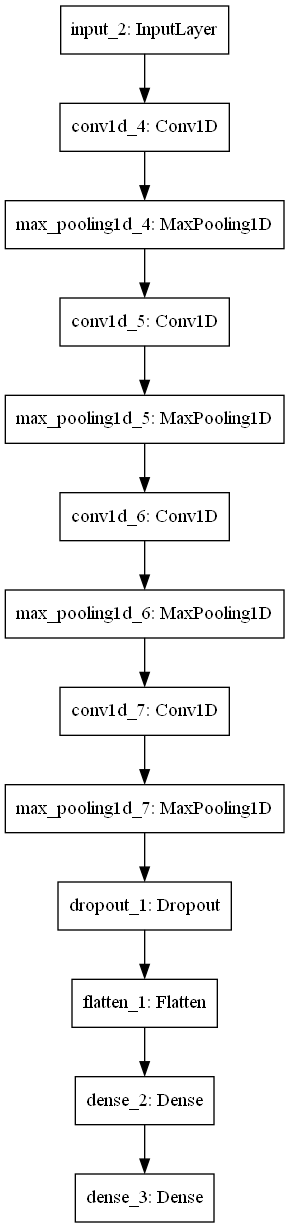

In [81]:
conv4_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=256, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(64,  activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

conv4_model.summary()

tf.keras.utils.plot_model(conv4_model)



Model already trained, load from:20221219211946/model/conv4/best_conv4.h5
Model already trained, load report from:20221219211946/model/conv4/report.json


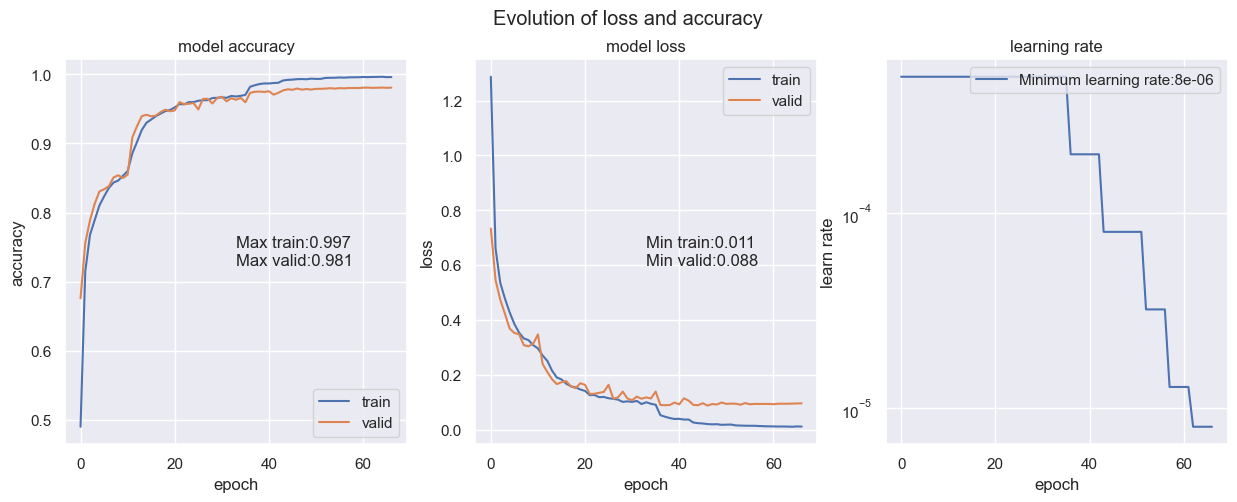

In [82]:
conv4_report = run_model(model=conv4_model,
                         x=x_train,
                         y=y_train,
                         model_name="conv4",
                         validation_data=(x_valid, y_valid),
                         #  validation_split=validation_split,
                         optimizer=optimizer,
                         batch_size=batch_size, epochs=300)
plot_training(conv4_model)


              precision    recall  f1-score   support

      APSK16     0.9805    0.9858    0.9832      2400
      APSK32     0.9403    0.9325    0.9364      2400
      APSK64     0.9565    0.9346    0.9454      2400
        ASK8     0.9996    1.0000    0.9998      2400
        BPSK     0.9979    0.9996    0.9988      2400
       OQPSK     1.0000    0.9992    0.9996      2400
       PSK16     0.9593    0.9733    0.9663      2400
        PSK8     0.9884    0.9942    0.9913      2400
      QAM128     0.9821    0.9804    0.9812      2400
       QAM16     0.9835    0.9946    0.9890      2400
      QAM256     0.9795    0.9579    0.9686      2400
       QAM64     0.9753    0.9867    0.9809      2400
        QPSK     0.9946    0.9996    0.9971      2400

    accuracy                         0.9799     31200
   macro avg     0.9798    0.9799    0.9798     31200
weighted avg     0.9798    0.9799    0.9798     31200



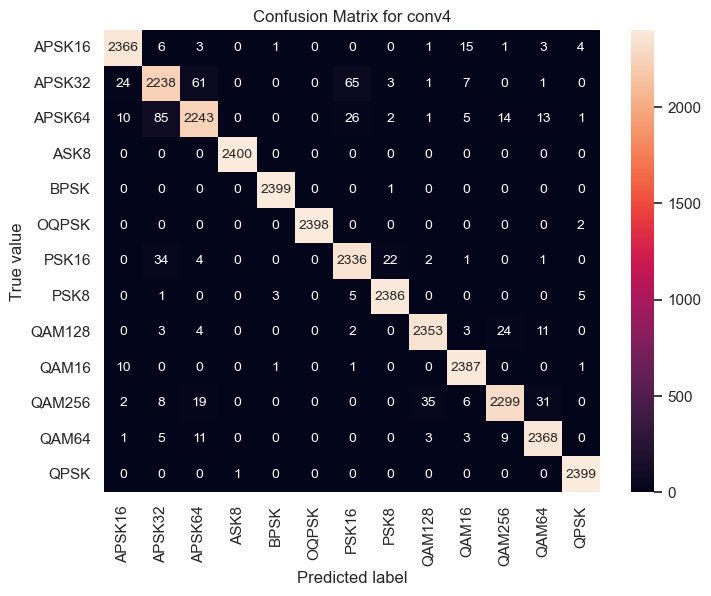

In [83]:
show_report(conv4_model, x_test_norm, y_test_onehot,"conv4")


### 5 Convolutional layers


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1010, 256)         61696     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 505, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 256)          459008    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 243, 128)          229504    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 121, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 128)          8

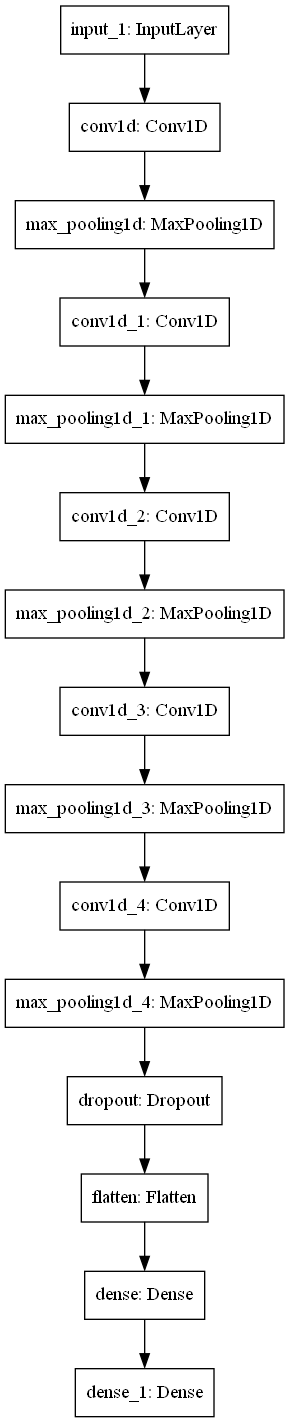

In [25]:
conv5_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=256, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=256, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Dropout(rate=0.6),
    keras.layers.Flatten(),
    keras.layers.Dense(64,  activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

conv5_model.summary()
tf.keras.utils.plot_model(conv5_model)



Model already trained, load from:20221219211946/model/conv5/best_conv5.h5
Model already trained, load report from:20221219211946/model/conv5/report.json


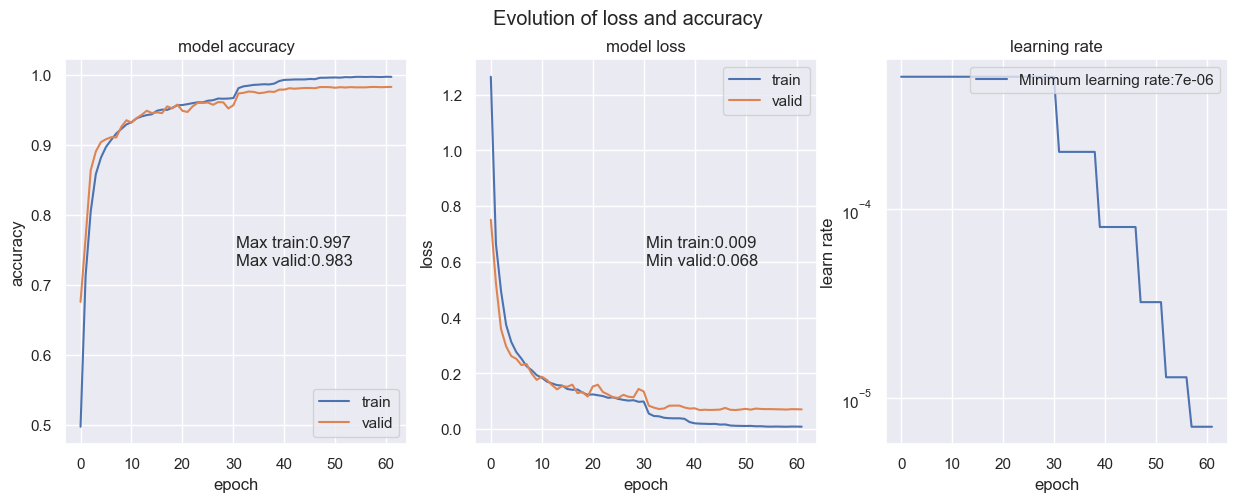

In [26]:
conv5_report = run_model(model=conv5_model,
                         x=x_train,
                         y=y_train,
                         model_name="conv5",
                         validation_data=(x_valid, y_valid),
                         # validation_split=0.3,
                         optimizer=optimizer,
                         batch_size=batch_size, epochs=300)
plot_training(conv5_model)


              precision    recall  f1-score   support

      APSK16     0.9776    0.9833    0.9805      2400
      APSK32     0.9465    0.9367    0.9416      2400
      APSK64     0.9606    0.9454    0.9530      2400
        ASK8     1.0000    0.9996    0.9998      2400
        BPSK     0.9983    1.0000    0.9992      2400
       OQPSK     0.9992    0.9921    0.9956      2400
       PSK16     0.9713    0.9729    0.9721      2400
        PSK8     0.9892    0.9962    0.9927      2400
      QAM128     0.9653    0.9846    0.9748      2400
       QAM16     0.9758    0.9929    0.9843      2400
      QAM256     0.9878    0.9454    0.9661      2400
       QAM64     0.9810    0.9879    0.9844      2400
        QPSK     0.9840    0.9996    0.9917      2400

    accuracy                         0.9797     31200
   macro avg     0.9797    0.9797    0.9797     31200
weighted avg     0.9797    0.9797    0.9797     31200



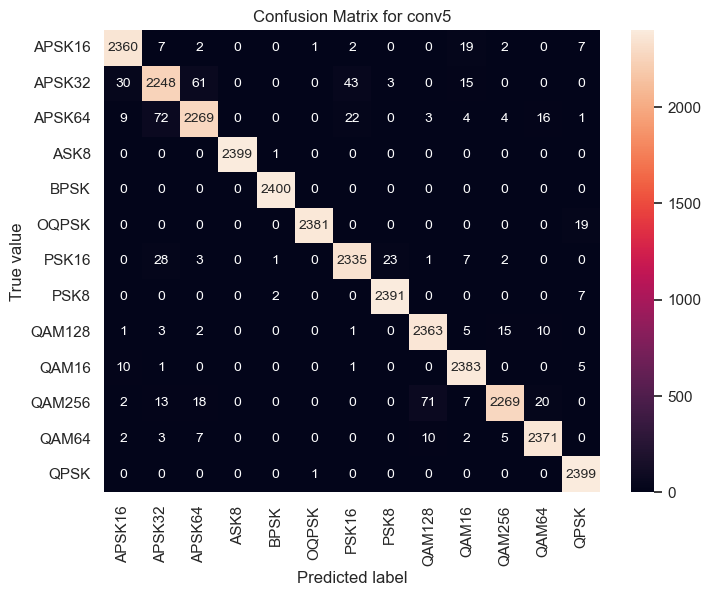

In [76]:
show_report(conv5_model,x_test_norm, y_test_onehot,"conv5")

### 5 Convolutional layers with Batch Normalization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1010, 256)         61696     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 505, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 256)          459008    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 243, 128)          229504    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 121, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 128)          8

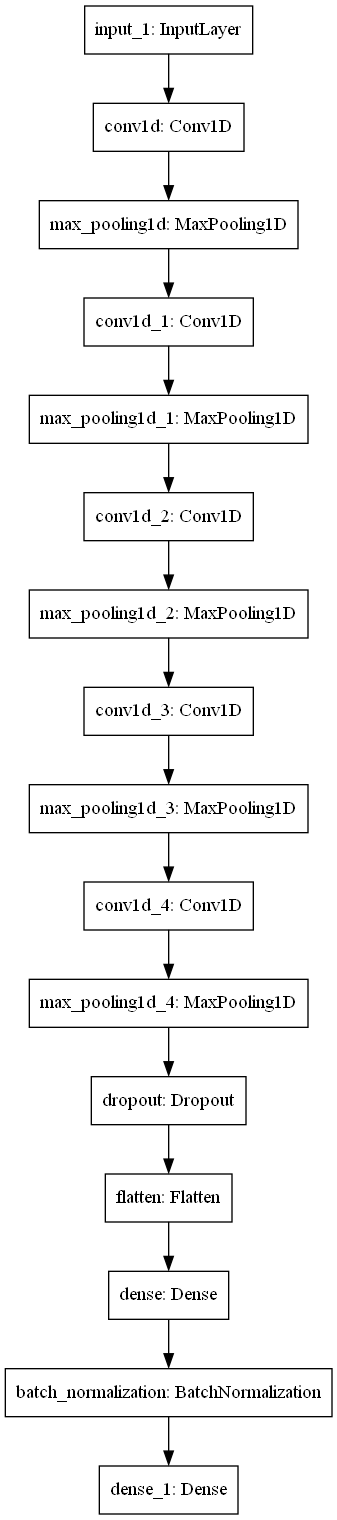

In [28]:
conv5_norm_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=256, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=256, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Dropout(rate=0.6),
    keras.layers.Flatten(),
    keras.layers.Dense(64,  activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

conv5_norm_model.summary()
tf.keras.utils.plot_model(conv5_norm_model)


Model already trained, load from:20221219211946/model/conv5_norm/best_conv5_norm.h5
Model already trained, load report from:20221219211946/model/conv5_norm/report.json


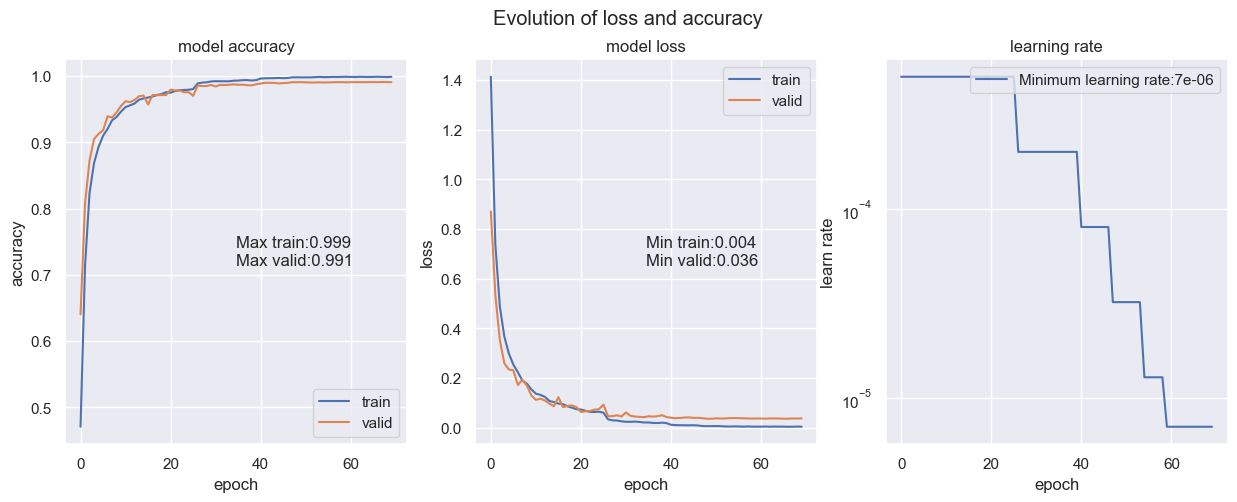

In [29]:
conv5_norm_report = run_model(model=conv5_norm_model,
                         x=x_train,
                         y=y_train,
                         model_name="conv5_norm",
                         validation_data=(x_valid, y_valid),
                         # validation_split=0.3,
                         optimizer=optimizer,
                         batch_size=batch_size, epochs=300)
plot_training(conv5_norm_model)


              precision    recall  f1-score   support

      APSK16     0.9904    0.9921    0.9913      2400
      APSK32     0.9802    0.9671    0.9736      2400
      APSK64     0.9679    0.9800    0.9739      2400
        ASK8     1.0000    1.0000    1.0000      2400
        BPSK     1.0000    1.0000    1.0000      2400
       OQPSK     1.0000    0.9971    0.9985      2400
       PSK16     0.9774    0.9896    0.9834      2400
        PSK8     0.9958    0.9962    0.9960      2400
      QAM128     0.9839    0.9900    0.9869      2400
       QAM16     0.9938    0.9946    0.9942      2400
      QAM256     0.9919    0.9700    0.9808      2400
       QAM64     0.9912    0.9904    0.9908      2400
        QPSK     0.9950    1.0000    0.9975      2400

    accuracy                         0.9898     31200
   macro avg     0.9898    0.9898    0.9898     31200
weighted avg     0.9898    0.9898    0.9898     31200



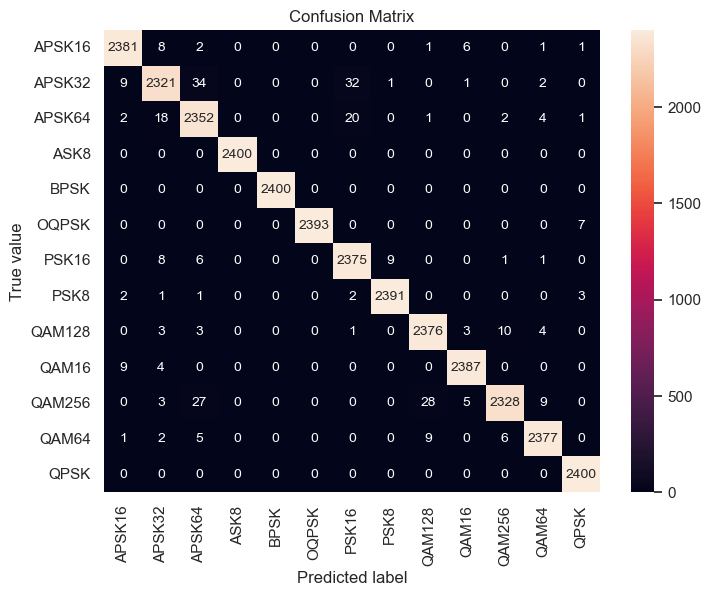

In [53]:
show_report(conv5_norm_model,x_test_norm, y_test_onehot)

### 3 conv + 2 LSTM


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1010, 128)         30848     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 505, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 128)          114816    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 247, 256)          98560     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 123, 256)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 123, 64)           8

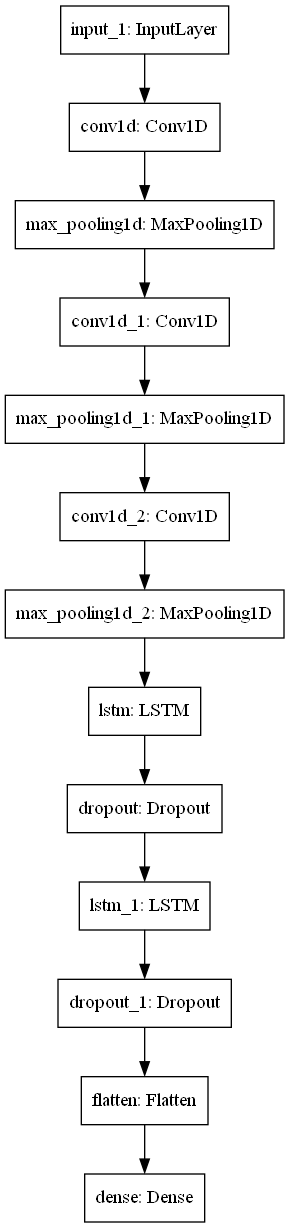

In [31]:
c3ldnn_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=128, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

c3ldnn_model.summary()
tf.keras.utils.plot_model(c3ldnn_model)



Model already trained, load from:20221219211946/model/c3ldnn/best_c3ldnn.h5
Model already trained, load report from:20221219211946/model/c3ldnn/report.json


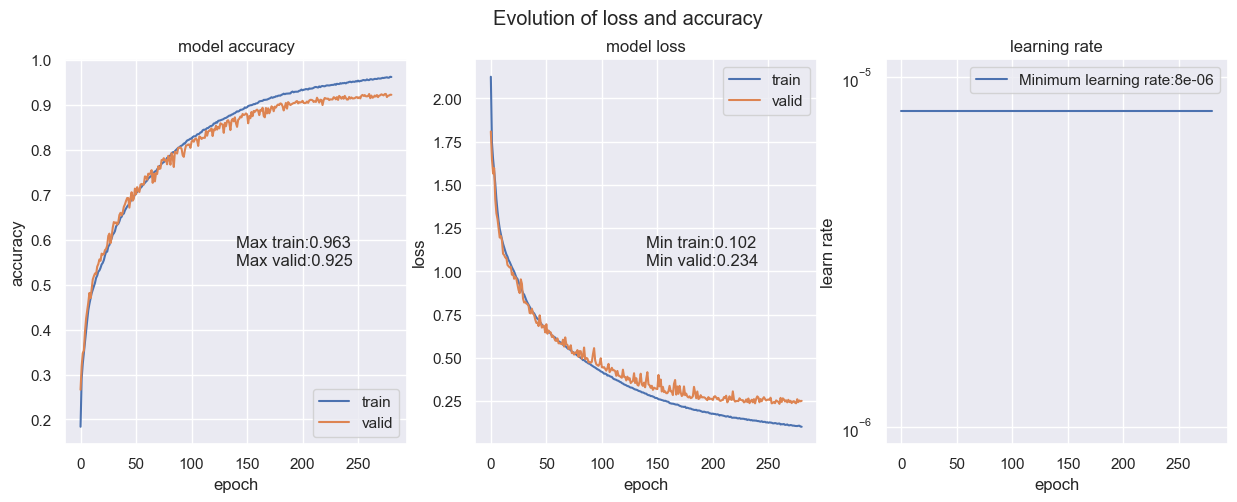

In [32]:
c3ldnn_report = run_model(model=c3ldnn_model,
                          x=x_train,
                          y=y_train,
                          model_name="c3ldnn",
                          validation_data=(x_valid, y_valid),
                          # validation_split=0.3,
                          optimizer=optimizer,
                          batch_size=batch_size, epochs=epochs)
plot_training(c3ldnn_model)


              precision    recall  f1-score   support

      APSK16     0.9104    0.9354    0.9227      2400
      APSK32     0.9038    0.8650    0.8840      2400
      APSK64     0.9151    0.8583    0.8858      2400
        ASK8     0.9983    0.9979    0.9981      2400
        BPSK     0.9975    0.9988    0.9981      2400
       OQPSK     0.9282    0.9637    0.9456      2400
       PSK16     0.9063    0.8983    0.9023      2400
        PSK8     0.9488    0.9650    0.9568      2400
      QAM128     0.8471    0.9000    0.8727      2400
       QAM16     0.8786    0.9442    0.9102      2400
      QAM256     0.8748    0.8125    0.8425      2400
       QAM64     0.9480    0.9275    0.9377      2400
        QPSK     0.9514    0.9379    0.9446      2400

    accuracy                         0.9234     31200
   macro avg     0.9237    0.9234    0.9232     31200
weighted avg     0.9237    0.9234    0.9232     31200



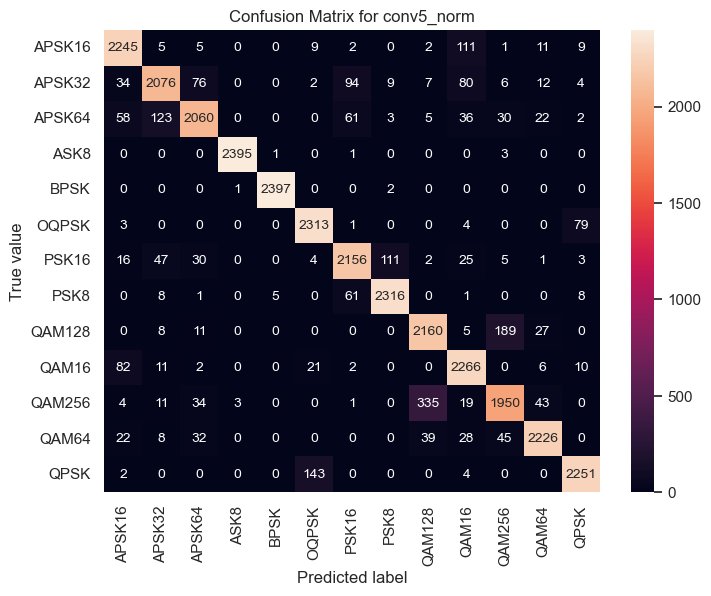

In [75]:
show_report(c3ldnn_model, x_test_norm, y_test_onehot,"conv5_norm")


### 5 Conv + 2 LSTM


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1010, 256)         61696     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 505, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 256)          459008    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 243, 128)          229504    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 121, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 128)          8

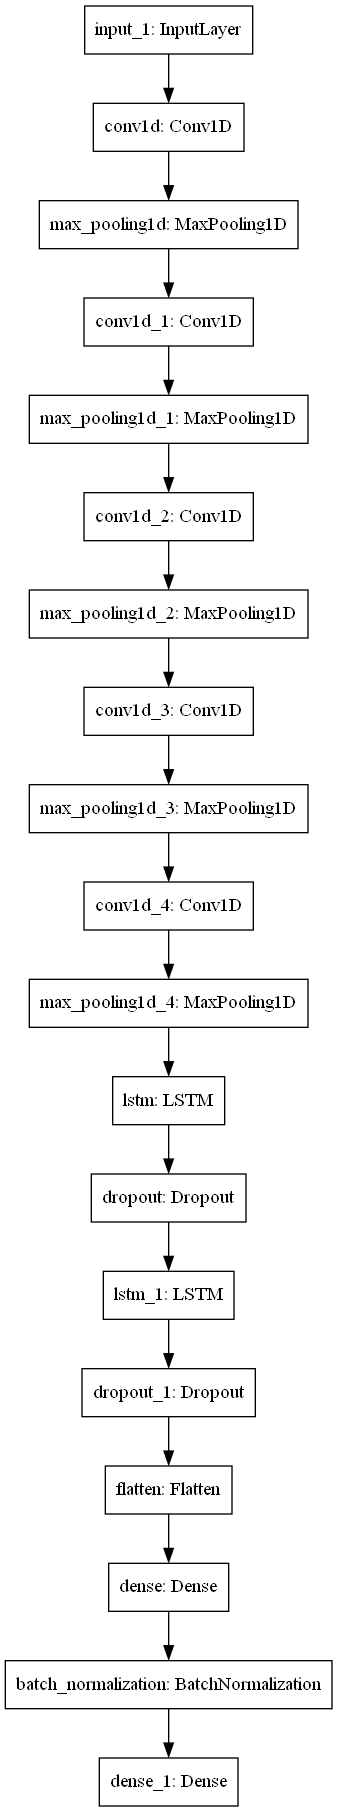

In [34]:
c5ldnn_model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv1D(filters=256, kernel_size=15, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=256, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(64,  activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(num_classes, activation='softmax'),
]
)

c5ldnn_model.summary()
tf.keras.utils.plot_model(c5ldnn_model)



Model already trained, load from:20221219211946/model/c5ldnn/best_c5ldnn.h5
Model already trained, load report from:20221219211946/model/c5ldnn/report.json


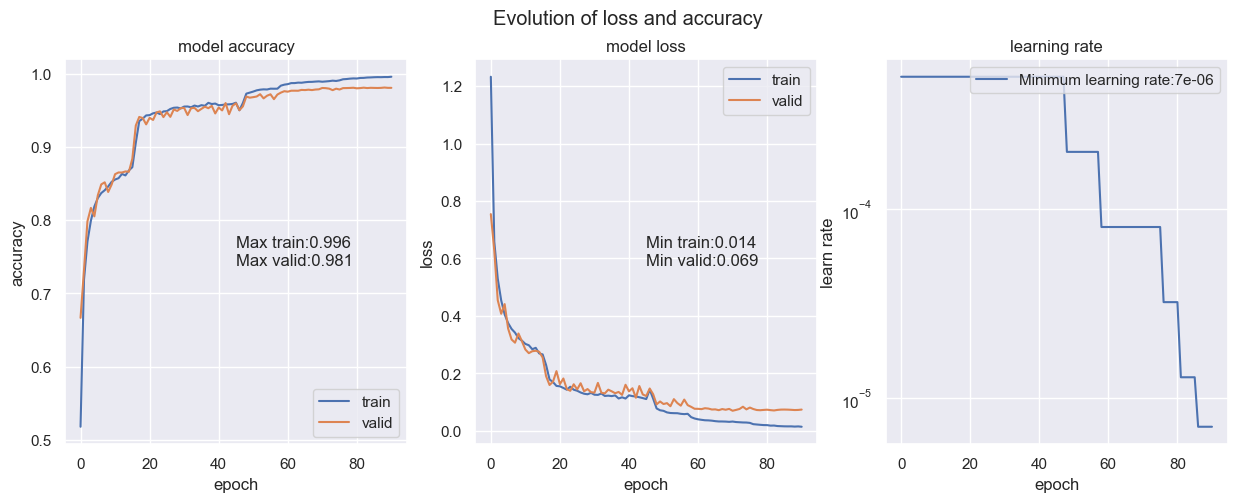

In [35]:

cv5ldnn_model_report = run_model(model=c5ldnn_model,
                                 x=x_train,
                                 y=y_train,
                                 model_name="c5ldnn",
                                 validation_data=(x_valid, y_valid),
                                 # validation_split=0.3,
                                 optimizer=optimizer,
                                 batch_size=batch_size, epochs=epochs)
plot_training(c5ldnn_model)

              precision    recall  f1-score   support

      APSK16     0.9709    0.9721    0.9715      2400
      APSK32     0.9384    0.9454    0.9419      2400
      APSK64     0.9644    0.9363    0.9501      2400
        ASK8     1.0000    0.9996    0.9998      2400
        BPSK     0.9992    1.0000    0.9996      2400
       OQPSK     0.9958    0.9938    0.9948      2400
       PSK16     0.9658    0.9663    0.9660      2400
        PSK8     0.9803    0.9950    0.9876      2400
      QAM128     0.9857    0.9767    0.9812      2400
       QAM16     0.9657    0.9846    0.9750      2400
      QAM256     0.9776    0.9621    0.9698      2400
       QAM64     0.9822    0.9867    0.9844      2400
        QPSK     0.9884    0.9958    0.9921      2400

    accuracy                         0.9780     31200
   macro avg     0.9780    0.9780    0.9780     31200
weighted avg     0.9780    0.9780    0.9780     31200



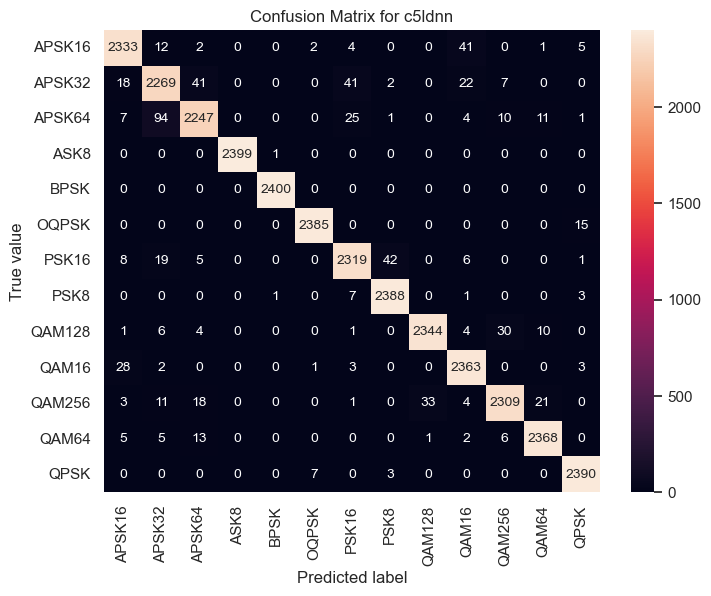

In [74]:
show_report(c5ldnn_model, x_test_norm, y_test_onehot,"c5ldnn")


# Selection of best model


In [36]:
x_test_norm, y_test_onehot = transform_dataset(X_test_data, Y_test_data)

# free memory
X_test_data = None
Y_test_data = None
gc.collect()


64553

In [37]:
def get_train_result_path(root=MODEL_FOLDER):
    model_names = [name for name in os.listdir(root)]
    file_path = {}
    for name in model_names:
        model_folder = f'{MODEL_FOLDER}/{name}'
        file_path[name] = {}
        list_dir = list(os.scandir(model_folder))
        for path in list_dir:
            p = path.path.replace('\\', '/')
            if path.is_file():
                if path.name.startswith('best'):
                    file_path[name]['best_model'] = p
                elif path.name.startswith('emissions'):
                    file_path[name]['emissions'] = p
                elif path.name.startswith('history'):
                    file_path[name]['history'] = p
                elif path.name.startswith('report'):
                    file_path[name]['report'] = p
        if len(file_path[name]) != 4:
            file_path.pop(name, None)
    return file_path


def get_result_df(result_path):
    names = []
    times = []
    emissions = []
    for name, paths in result_path.items():
        with open(paths['report']) as f:
            report = json.load(f)
            names.append(name)
            times.append(report['train_time'])
        emi = pd.read_csv(paths['emissions'])
        emissions.append(emi["emissions"][0])
    return pd.DataFrame({
        "model name": names,
        "training time": times,
        "emissions": emissions
    })


In [38]:
x_train=None
y_train=None
x_valid=None
y_valid=None
gc.collect()

0

# Best models selection


In [54]:
def get_train_result_path(root=MODEL_FOLDER):
    model_names = [name for name in os.listdir(root)]
    file_path = {}
    for name in model_names:
        model_folder = f'{MODEL_FOLDER}/{name}'
        file_path[name] = {}
        list_dir = list(os.scandir(model_folder))
        for path in list_dir:
            p = path.path.replace('\\', '/')
            if path.is_file():
                if path.name.startswith('best'):
                    file_path[name]['best_model'] = p
                elif path.name.startswith('emissions'):
                    file_path[name]['emissions'] = p
                elif path.name.startswith('history'):
                    file_path[name]['history'] = p
                elif path.name.startswith('report'):
                    file_path[name]['report'] = p
        if len(file_path[name]) != 4:
            file_path.pop(name, None)
    return file_path


def get_report_conf(model, x_test_norm, y_test_onehot, labels=MOD):
    keras.backend.clear_session()
    # force free memory
    gc.collect()
    start = time.time()

    class_true, class_pred = get_true_pred(model, x_test_norm, y_test_onehot)
    conf_mat = get_conf_matrix(class_true, class_pred, )
    pred_time = time.time()-start
    report = classification_report(class_true, class_pred, output_dict=True)
    df = pd.DataFrame(report)

    mods = [f'{i}-{name}' for i, name in enumerate(labels)]
    idx = [str(i) for i in range(len(labels))]
    report = df.drop(["support"], axis=0).drop(
        ["weighted avg", "macro avg", "accuracy"], axis=1).transpose()
    report['metric'] = mods
    return report, conf_mat, df['accuracy'], pred_time


def get_model_report(result_path):
    names = []
    times = []
    emissions = []
    for name, paths in result_path.items():
        with open(paths['report']) as f:
            report = json.load(f)
            names.append(name)
            times.append(report['train_time']/60)
        emi = pd.read_csv(paths['emissions'])
        emissions.append(emi["emissions"][0])
    return pd.DataFrame({
        "model name": names,
        "training time": times,
        "emissions": emissions
    })


def get_pred_results(result_path, x_test_norm, y_test_onehot):
    details = []
    model_names = []
    accuracies = []
    se = []
    pred_times = []
    confs = {}
    for name, paths in result_path.items():
        model_name = result_path[name]
        best_model = keras.models.load_model(paths['best_model'])
        report, conf, accuracy, pred_time = get_report_conf(
            best_model, x_test_norm, y_test_onehot)
        report['model name'] = [name]*len(report)
        details.append(report)
        model_names.append(name)
        accuracies.append(accuracy[0])
        se.append(report[report['model name'] == name]["precision"].sem())
        pred_times.append(pred_time)
        confs[name] = conf
    return pd.concat(details, axis=0), pd.DataFrame(
        {
            'model name': model_names,
            "accuracy": accuracies,
            "se": se,
            "predict time": pred_times
        }
    ), confs


In [55]:
result_path = get_train_result_path()
model_report = get_model_report(result_path)
model_details, model_stat, confs = get_pred_results(
    result_path, x_test_norm, y_test_onehot)


In [56]:
display(model_report)
display(model_stat)


,model name,training time,emissions
0,c5ldnn,34.526021,0.080276
1,conv4,11.914631,0.034531
2,conv5,12.642474,0.038565
3,conv5_norm,18.602634,0.053591


,model name,accuracy,se,predict time
0,c5ldnn,0.978013,0.004768,4.688156
1,conv4,0.979872,0.005051,2.409684
2,conv5,0.979744,0.004441,2.522271
3,conv5_norm,0.989776,0.002728,2.621807


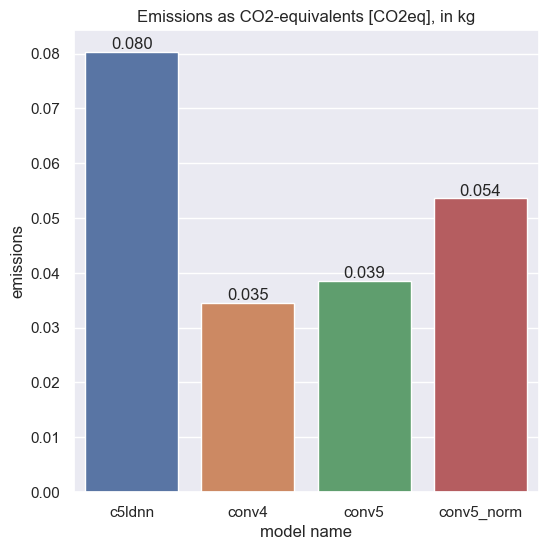

In [57]:
plt.figure(figsize=(6, 6))
sns.color_palette("tab10")
g = sns.barplot(x="model name", y="emissions", data=model_report)
g.set_title("Emissions as CO2-equivalents [CO2eq], in kg")

for container in g.containers:
    g.bar_label(container, fmt="%.3f", padding=0)
plt.show()


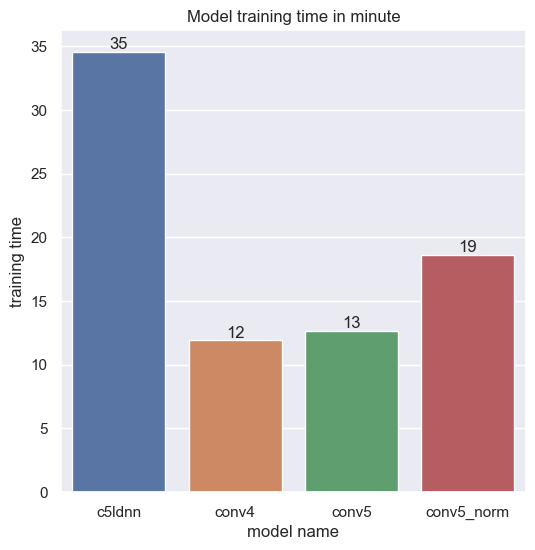

In [58]:
plt.figure(figsize=(6, 6))
sns.color_palette("tab10")
g = sns.barplot(x="model name", y="training time", data=model_report)
g.set_title("Model training time in minute")
for container in g.containers:
    g.bar_label(container, fmt="%.0f", padding=0)
plt.show()


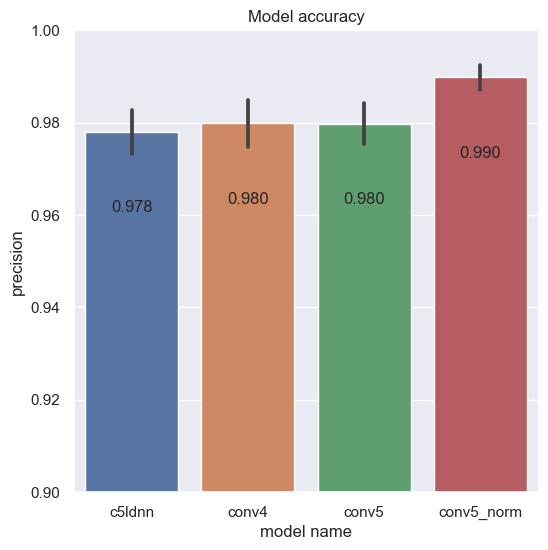

In [59]:
plt.figure(figsize=(6, 6))
sns.color_palette("tab10")
g = sns.barplot(x="model name", y="precision",
                data=model_details, orient="v", errorbar="se")
g.set_title("Model accuracy by class")
g.set(ylim=(0.90, 1))
g.set_title("Model accuracy")
pd
for container in g.containers:
    g.bar_label(container, fmt="%.3f", padding=-60)

plt.show()


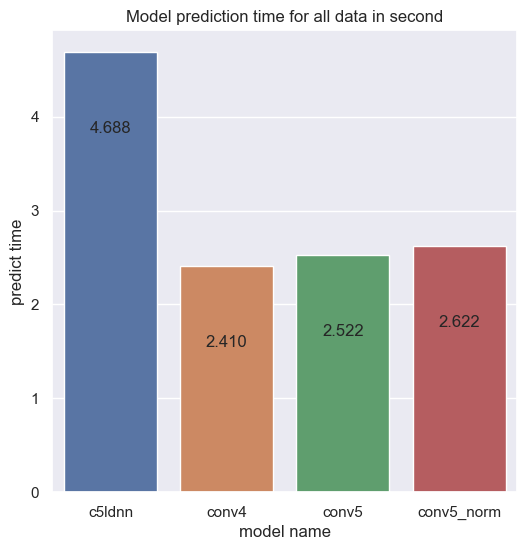

In [71]:
plt.figure(figsize=(6, 6))
sns.color_palette("tab10")
g = sns.barplot(x="model name", y="predict time",
                data=model_stat, orient="v")
g.set_title("Model prediction time for all data in second")
pd
for container in g.containers:
    g.bar_label(container, fmt="%.3f", padding=-60)

plt.show()


In [60]:
best_model_stat = model_stat[model_stat['accuracy']==model_stat['accuracy'].max()]
best_model_stat


,model name,accuracy,se,predict time
3,conv5_norm,0.989776,0.002728,2.621807


In [61]:
best_model_name = (str(best_model_stat.iloc[0, 0]))
best_model_name


'conv5_norm'

In [62]:
best_model = keras.models.load_model(get_best_model_path(best_model_name,fine_tune=False))
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1010, 256)         61696     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 505, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 256)          459008    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 243, 128)          229504    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 121, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 128)          8

# Cross validation


In [63]:
def get_stratifiedSplitIdx(X, Y, n=4, train_size=0.7, random_state=RANDOM_SEED):
    gc.collect()
    sss = StratifiedShuffleSplit(
        n_splits=n, train_size=train_size, random_state=random_state)
    return sss.split(X.reshape((X.shape[0],X.shape[1]*X.shape[2])), Y)





In [64]:
def cross_validation(model, model_name, x_train, y_train, n=4, train_size=0.7, show_training_plot=False):
    splits_idx = get_stratifiedSplitIdx( x_train, y_train, n=n, train_size=train_size)
    for i, (train_index, test_index) in enumerate(splits_idx):
        print(f"training with split:{i+1}, with {train_index.shape[0]} samples")
        run_model(model=model,
                  x=x_train[train_index],
                  y=y_train[train_index],
                  model_name=model_name,
                  validation_data=(x_train[test_index], y_train[test_index]),
                  optimizer=optimizer,
                  batch_size=batch_size, epochs=epochs,
                  use_gpu=True,
                  fine_tune=True)
        if show_training_plot:
            plot_training(model)
        
    return model


In [ ]:
x_train_cross, y_train_cross = transform_dataset(X_data, Y_data)
X_data = None
Y_data = None
gc.collect()

In [ ]:
#fine_tuned_best_model = cross_validation(
#    best_model, best_model_name, x_train_cross, y_train_cross,n=10, train_size=0.7, show_training_plot=True)




# Best model


              precision    recall  f1-score   support

      APSK16     0.9913    0.9942    0.9927      2400
      APSK32     0.9836    0.9767    0.9801      2400
      APSK64     0.9817    0.9808    0.9812      2400
        ASK8     1.0000    1.0000    1.0000      2400
        BPSK     1.0000    1.0000    1.0000      2400
       OQPSK     1.0000    0.9971    0.9985      2400
       PSK16     0.9843    0.9921    0.9882      2400
        PSK8     0.9967    0.9979    0.9973      2400
      QAM128     0.9875    0.9896    0.9886      2400
       QAM16     0.9929    0.9962    0.9946      2400
      QAM256     0.9924    0.9808    0.9866      2400
       QAM64     0.9921    0.9925    0.9923      2400
        QPSK     0.9954    1.0000    0.9977      2400

    accuracy                         0.9921     31200
   macro avg     0.9921    0.9921    0.9921     31200
weighted avg     0.9921    0.9921    0.9921     31200



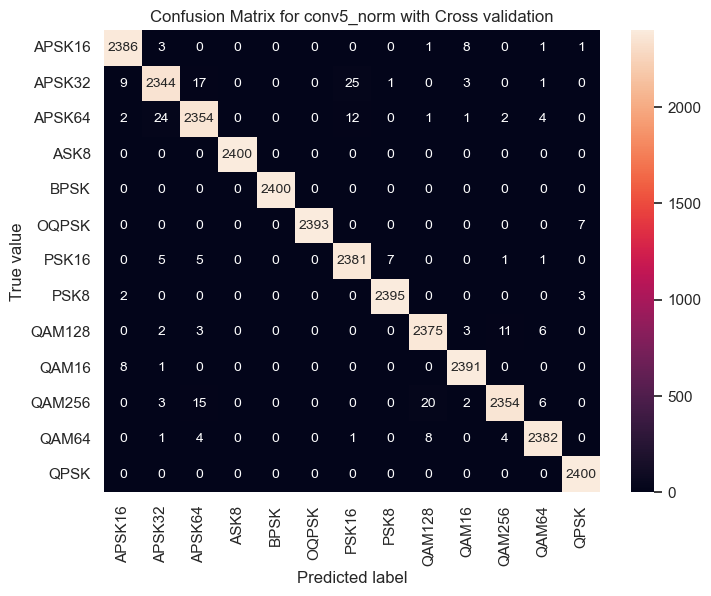

In [72]:
best_model = keras.models.load_model("20221219211946/model/conv5_norm/fine_tune/best_conv5_norm.h5")

show_report(best_model, x_test_norm, y_test_onehot,model_name="conv5_norm with Cross validation")


              precision    recall  f1-score   support

      APSK16     0.9829    0.9821    0.9825      2400
      APSK32     0.9602    0.9446    0.9523      2400
      APSK64     0.9675    0.9563    0.9619      2400
        ASK8     0.9996    1.0000    0.9998      2400
        BPSK     0.9988    1.0000    0.9994      2400
       OQPSK     1.0000    0.9983    0.9992      2400
       PSK16     0.9602    0.9654    0.9628      2400
        PSK8     0.9794    0.9883    0.9838      2400
      QAM128     0.9896    0.9867    0.9881      2400
       QAM16     0.9775    0.9946    0.9860      2400
      QAM256     0.9932    0.9762    0.9847      2400
       QAM64     0.9872    0.9933    0.9902      2400
        QPSK     0.9893    0.9996    0.9944      2400

    accuracy                         0.9835     31200
   macro avg     0.9835    0.9835    0.9835     31200
weighted avg     0.9835    0.9835    0.9835     31200



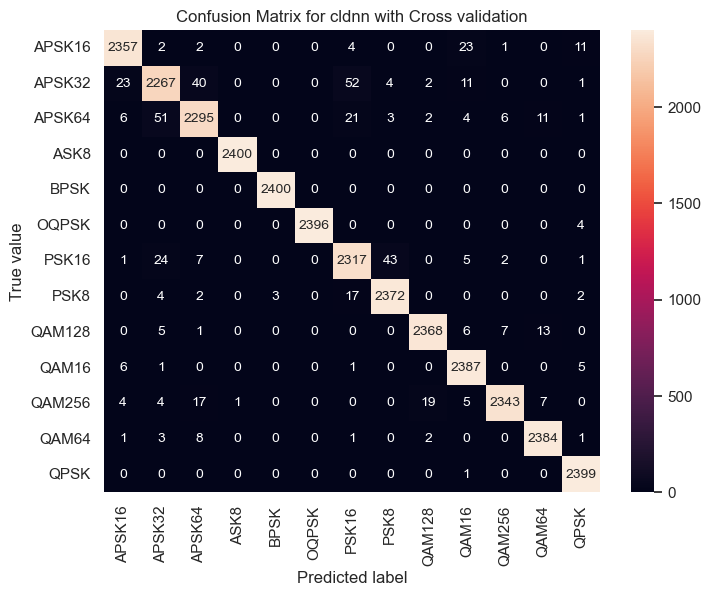

In [85]:
best_cldnn = keras.models.load_model(
    "best_cldnn.h5")

show_report(best_cldnn, x_test_norm, y_test_onehot,
            model_name="cldnn with Cross validation")
